<a href="https://colab.research.google.com/github/MrDegglan/9785-crypto-ml/blob/Raouf-Younes/ML_Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Library Import
https://trello.com/b/8l8sGsy8/project-proposal

In [ ]:
!pip install cryptocmd

!pip install numpy
!pip install pandas
!pip install -U scikit-learn
!pip install matplotlib
!pip install seaborn
!pip install statsmodels

# jupyter notebook   --NotebookApp.allow_origin='https://colab.research.google.com'   --port=8888   --NotebookApp.port_retries=0

tabular vs multidimensional

pandas used for tabular data, statistics 

numpy used for multidimentional like images

In [ ]:
# Library for crypto currency prediction
from cryptocmd import CmcScraper

# Dependency for pandas, provides arrays, < 50K
import numpy as np

# adds support for DataFrames, > 500K
import pandas as pd

# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Seasonality anaylsis
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from pylab import rcParams

# MinMaxScalar normalises numeric data between 0 and 1 for the purpose of ML training
from sklearn.preprocessing import StandardScaler, MinMaxScaler, scale
from sklearn.preprocessing import LabelEncoder

# Used for making a train and test split
from sklearn.model_selection import train_test_split

# If training new models set TRAINING to true
TRAINING = True

# If running on local machine set LOCAL to true, Neccessary for training.
LOCAL = True

# Hourly Data Source
HOURLY = True

In [ ]:
if(LOCAL):
  model_simple_path = './Models/RNN_LSTM_SIMPLE/'
  model_complex_path = './Models/RNN_LSTM_COMPLEX/'
  gru_base_path = './Models/RNN_GRU_BASE/'
  Hourly_Data_Path = './Gemini_BTCUSD_1h.csv'
   
else:
  from google.colab import drive
  drive.mount('/content/drive')
  
  if(HOURLY):
    Hourly_Data_Path = '/content/drive/MyDrive/9785_Colab_Notebooks/Data/Gemini_BTCUSD_1h.csv'
    model_simple_path = '/content/drive/MyDrive/9785_Colab_Notebooks/Ml_Models/Hourly/RNN_LSTM_SIMPLE/'
    model_complex_path = '/content/drive/MyDrive/9785_Colab_Notebooks/Ml_Models/Hourly/RNN_LSTM_COMPLEX/'
    gru_base_path = '/content/drive/MyDrive/9785_Colab_Notebooks/Ml_Models/Hourly/RNN_GRU_BASE/'
  else:
    model_simple_path = '/content/drive/MyDrive/9785_Colab_Notebooks/Ml_Models/Daily/RNN_LSTM_SIMPLE/'
    model_complex_path = '/content/drive/MyDrive/9785_Colab_Notebooks/Ml_Models/Daily/RNN_LSTM_COMPLEX/'
    gru_base_path = '/content/drive/MyDrive/9785_Colab_Notebooks/Ml_Models/Daily/RNN_GRU_BASE/'


# Data Download and preperation

In [ ]:
# Data Import
if(HOURLY):
  data = pd.read_csv(Hourly_Data_Path,skiprows=1)
  data.columns = [x.strip().lower().replace(' ','_') for x in data.columns]
  display(data)
else:
  # ==============================================================================
  # Scraper is initialized, symbol, start and end of download are included
  scraper = CmcScraper('BTC', '28-04-2013', '24-08-2022')
  # Transform collected data into a dataframe
  data = scraper.get_dataframe()
  data.columns = [x.strip().lower().replace(' ','_') for x in data.columns]
  display(data)

In [ ]:
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d %H:%M:%S')#.astype(int) / 10**9
data['hour'] = data['date'].dt.hour
data['day'] = data['date'].dt.day
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year
data_raw = data
data = data.drop(['date','unix','symbol'], axis=1,errors='ignore')

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
  display(data.head(30))
  print(len(data))

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
normalised_data = scaler.fit_transform(data)
type(normalised_data),normalised_data.shape,normalised_data[0],scaler.inverse_transform(normalised_data[0:1])[0][3],data.iloc[0:1,3:4]

In [ ]:
x_train = []
#y_train = data.iloc[:,3:4].values
# use this to train on normalised_Y
y_train = []


# Looping over everyday starting from day number 60
for i in range (30, normalised_data.shape[0]):
    # the ,0 in the second index means to access the first coloumn in that row otherwise we will gettraining_set_scaled[i,0]
    x_train.append(normalised_data[i-30:i,0:10]) # data of days 0 to 59 as upper bound :i,0] is not inclusive

    # use this to train on normalised_Y
    y_train.append(normalised_data[i,3:4]) # data of the 60th day (the true result)
    # y_train.append(data.iloc[i,3:4])
# taking the batches of data and transforming it into a numpy array instead of a list
x_train, y_train = np.array(x_train),np.array(y_train)

In [ ]:
type(data.iloc[1:,3:4].values),data.iloc[30:,3:4].values.shape,data.iloc[30:,3:4].values[0]

In [ ]:
type(y_train),y_train.shape,y_train[0]

In [ ]:
type(x_train),x_train.shape

In [ ]:
x = reverse_inverse(y_train, x_train)
type(x),x.shape,x[0]

In [ ]:
for num in x:
    if(num == 19759.56):
        print(num)

In [ ]:
SAMPLE_SIZE = 2405
X_train, X_test = x_train[:-SAMPLE_SIZE], x_train[-SAMPLE_SIZE:]
Y_train, Y_test = y_train[:-SAMPLE_SIZE], y_train[-SAMPLE_SIZE:]

In [ ]:
# for i in range(0,len(x_train)):
#   #print(i)
#   for j in range(X_train.shape[1]):
#     if(x_train[i][j][3] == y_train[0]):
#       print(i,j)

## Visualization and Initial Analysis

In [ ]:
# Select close price and date column from a raw dataset
BTC_close = data_raw[['date', 'close']]

# print first and last point in dataset
pd.DataFrame({'First' : [BTC_close['date'].min()],'Last' :  [BTC_close['date'].max()]})

In [ ]:
# Summary target variable
BTC_close['close'].describe()

In [ ]:
import matplotlib.dates as mdates

# Setting the date as index (time series)
BTC_ts = BTC_close.set_index('date')

plt.rcParams["figure.figsize"] = [15, 8]
plt.rcParams["figure.autolayout"] = True

series = BTC_ts.loc[(BTC_ts.index > BTC_ts.index.max() - pd.DateOffset(years=5)) & (BTC_ts.index <= BTC_ts.index.max())]
ax = series.plot()
ax.xaxis.set_major_locator(mdates.YearLocator(1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gcf().autofmt_xdate()
plt.grid(which='major',axis ='x', linewidth='1', color='black')
plt.xlim(series.index.min(), series.index.max())
plt.xlabel('Date', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.title('Hourly Development of BTC Price', fontsize=16)

plt.show()

In [ ]:
#BTC growth analysis
growth = BTC_ts.loc[(BTC_ts.index > BTC_ts.index.max() - pd.DateOffset(years=5)) & (BTC_ts.index <= BTC_ts.index.max())]
# Plot
x = growth.index.values
y1 = growth['close'].values

# Plot
fig, ax = plt.subplots(1, 1, figsize=(16,5), dpi= 120)
plt.fill_between(x, y1=y1, y2=-y1, alpha=0.5, linewidth=2, color='seagreen')
plt.title('BTC growth analysis', fontsize=16)
plt.hlines(y=0, xmin=np.min(growth.index), xmax=np.max(growth.index), linewidth=.5)
plt.xlim(growth.index.min(), growth.index.max())
plt.ylim(-abs(growth['close'].max()), growth['close'].max())
plt.show()

In [ ]:
# data seasonality analysis
season = BTC_ts.loc[(BTC_ts.index > BTC_ts.index.max() - pd.DateOffset(months=1)) & (BTC_ts.index <= BTC_ts.index.max())]

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(season, model='additive', freq = 24)
fig = decomposition.plot()
plt.show()

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120})
# Import Data
df = BTC_ts

# Multiplicative Decomposition 
result_mul = seasonal_decompose(df['close'], model='multiplicative', extrapolate_trend='freq', freq = 24)

# Additive Decomposition
result_add = seasonal_decompose(df['close'], model='additive', extrapolate_trend='freq', freq = 24)

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()

In [ ]:
from statsmodels.tsa.stattools import adfuller, kpss

# ADF Test
result = adfuller(BTC_ts.close.values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

# KPSS Test
result = kpss(BTC_ts.close.values, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

In [ ]:
from pandas.plotting import autocorrelation_plot

# Draw Plot
plt.rcParams.update({'figure.figsize':(9,5), 'figure.dpi':120})
autocorrelation_plot(BTC_ts.close.tolist())

In [ ]:
# autocorrelation and partial autocorrelation functions
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Calculate ACF and PACF upto 50 lags
# acf_50 = acf(df.value, nlags=50)
# pacf_50 = pacf(df.value, nlags=50)

# Draw Plot
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(BTC_ts.close.tolist(), lags=50, ax=axes[0])
plot_pacf(BTC_ts.close.tolist(), lags=50, ax=axes[1])

# Build Tensorflow Model

## Standard Imports

In [ ]:
# Importing Tensorflow
import tensorflow as tf
print(tf.__version__)

# Declares a base class called sequential to add model layers on 
from tensorflow.keras.models import Sequential

# Dense layer is final output 1d layer
# Dropout layer protects against overfitting 
from tensorflow.keras.layers import Dense, Dropout

# RNN LSTM layer
from tensorflow.keras.layers import LSTM,GRU

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Mounting google drive for save
# Moved up

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

## Building RNN - LSTM

In [ ]:
model_simple=Sequential()
model_simple.add(LSTM(50,return_sequences=True,input_shape=(x_train.shape[1],x_train.shape[2])))
model_simple.add(LSTM(50,return_sequences=True))
model_simple.add(LSTM(50))
model_simple.add(Dense(1))
model_simple.compile(loss='mean_squared_error', optimizer='adam')
# ~200

In [ ]:
model_complex=Sequential()
model_complex.add(LSTM(256,return_sequences=True,input_shape=(x_train.shape[1],x_train.shape[2])))
model_complex.add(Dropout(rate=0.2))
model_complex.add(LSTM(512,return_sequences=True))
model_complex.add(Dropout(rate=0.4))
model_complex.add(LSTM(512,return_sequences=True))
model_complex.add(Dropout(rate=0.4))
model_complex.add(LSTM(256))
model_complex.add(Dense(1))
model_complex.compile(loss='mean_squared_error', optimizer='adam')
# ~200

In [ ]:
if(TRAINING):
  callbacks_simple = [EarlyStopping(monitor='val_loss', patience=100),
              ModelCheckpoint(model_simple_path, monitor='loss', save_best_only=True, mode='min')]
  callbacks_complex = [EarlyStopping(monitor='val_loss', patience=100),
              ModelCheckpoint(model_complex_path, monitor='loss', save_best_only=True, mode='min')]
  model_simple.fit(x_train, y_train,validation_split=0.2,epochs=3000,batch_size=32,verbose=1,callbacks=callbacks_simple)
  model_complex.fit(x_train, y_train,validation_split=0.2,epochs=3000,batch_size=64,verbose=1,callbacks=callbacks_complex)
else:
  model_simple.load_weights(model_simple_path)
  model_complex.load_weights(model_complex_path)

In [ ]:
predictions_simple = model_simple.predict(X_test)
# predictions_simple,reverse_inverse(predictions_simple, X_test)[1],reverse_inverse(Y_test, X_test)[1]
predictions_complex = model_complex.predict(X_test)

## RNN - GRU

In [ ]:
GRU_Base=Sequential()
GRU_Base.add(GRU(50,return_sequences=True,input_shape=(x_train.shape[1],x_train.shape[2])))
GRU_Base.add(GRU(50,return_sequences=True))
GRU_Base.add(GRU(50))
GRU_Base.add(Dense(1))
GRU_Base.compile(loss='mean_squared_error', optimizer='adam')
#1500~

In [ ]:
callbacks_base = [EarlyStopping(monitor='val_loss', patience=100),
            ModelCheckpoint(gru_base_path, monitor='loss', save_best_only=True, mode='min')]
GRU_Base.fit(x_train, y_train,validation_split=0.2,epochs=3000,batch_size=32,verbose=1,callbacks=callbacks_base)

In [ ]:
GRU_PRED_BASE = GRU_Base.predict(X_test)

# Visualise the model predictions

In [ ]:
def reverse_inverse(pred, originalData):
  matrix = np.zeros(shape=(originalData.shape[0], originalData.shape[2]))
  x=pred.reshape(-1,)
  matrix[:,3] = x
  return scaler.inverse_transform(matrix)[:,3]

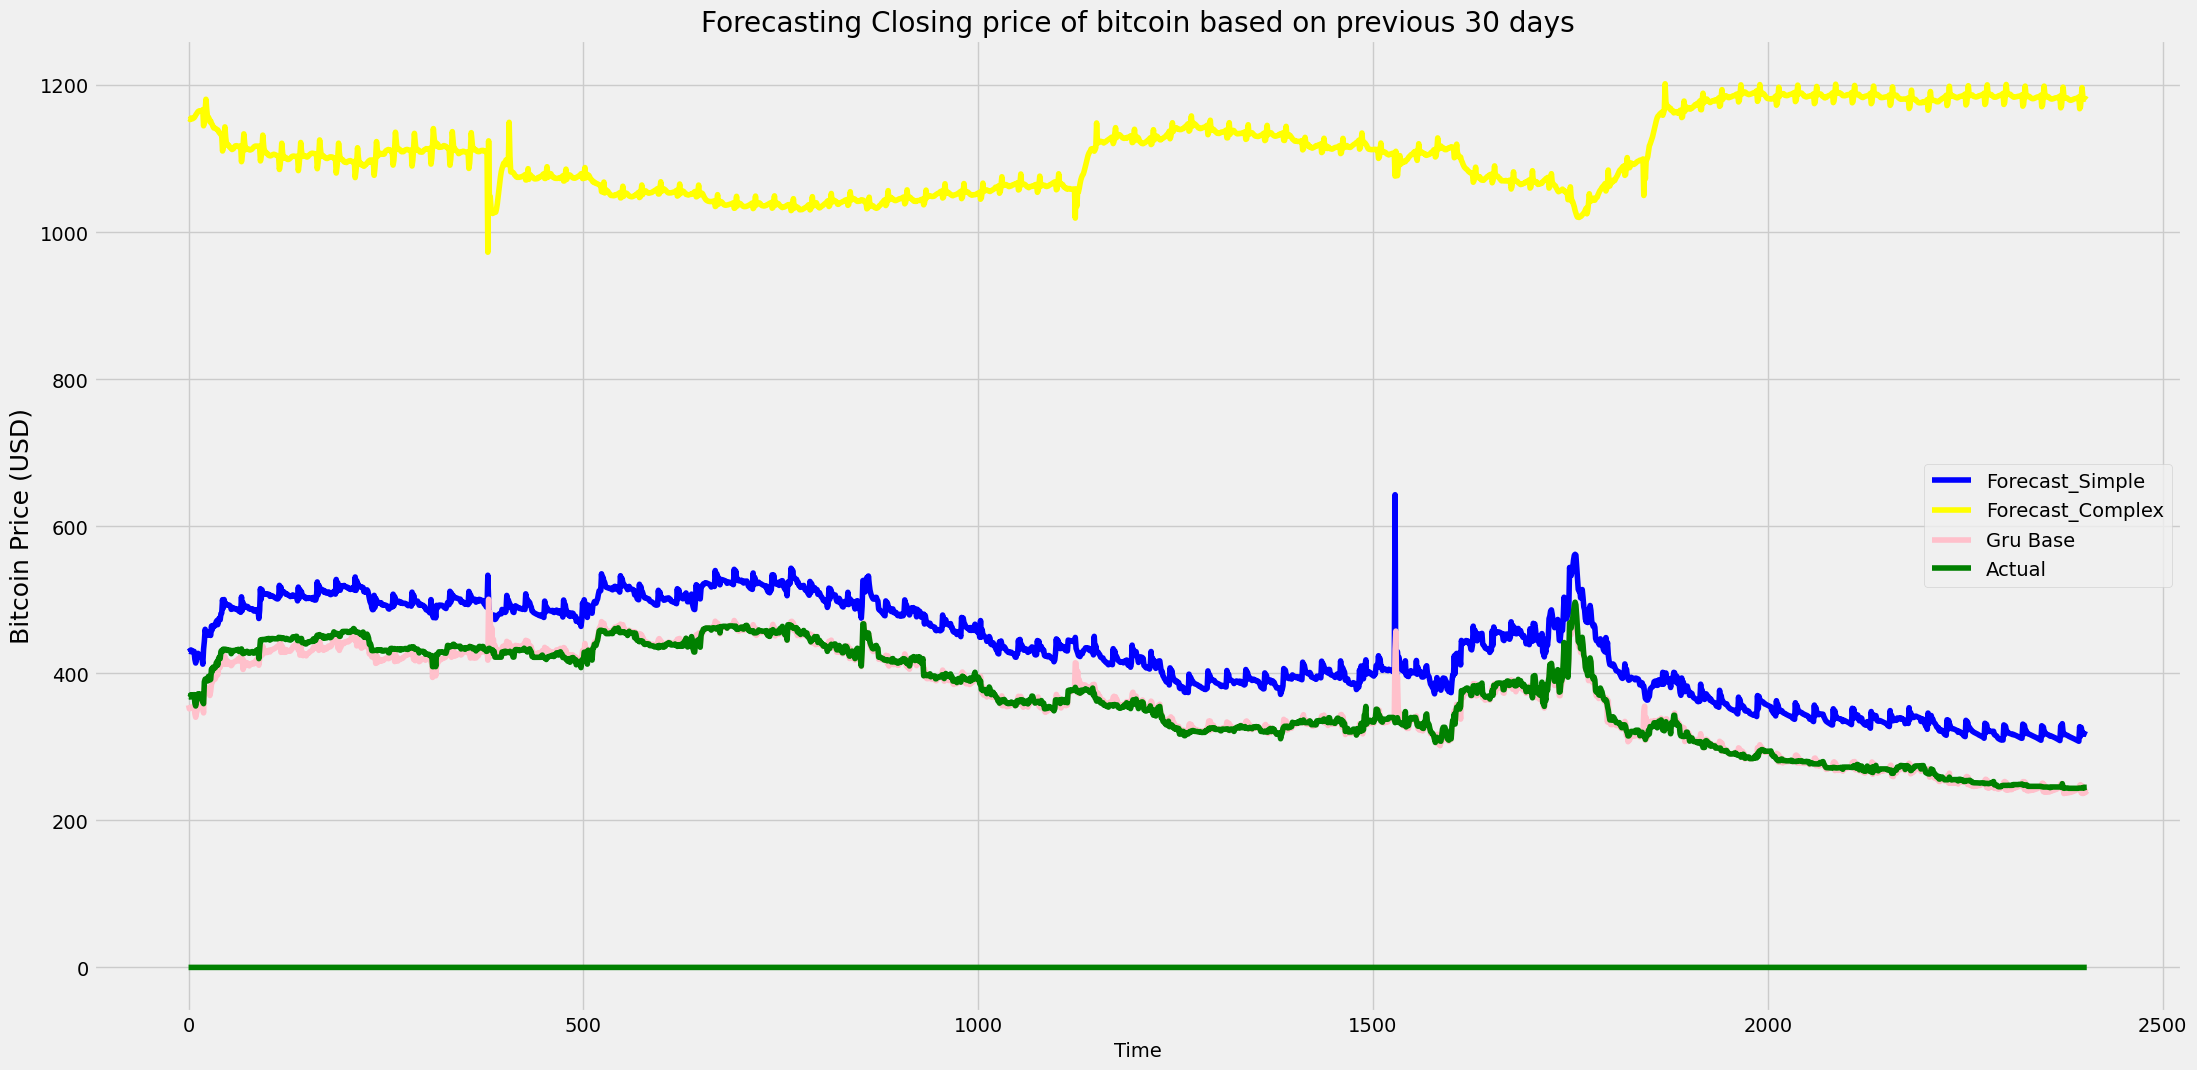

In [192]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.figure(figsize=(24,12))
plt.title('Forecasting Closing price of bitcoin based on previous 30 days')
plt.xlabel('Time', fontsize=14) # Fix Timeing
plt.ylabel('Bitcoin Price (USD)', fontsize=18)
plt.plot(reverse_inverse(predictions_simple, X_test), color='blue')
plt.plot(reverse_inverse(predictions_complex, X_test), color='yellow')
plt.plot(reverse_inverse(GRU_PRED_BASE, X_test),color='pink')
plt.plot(reverse_inverse(Y_test, X_test),color='green')
plt.plot(Y_test,color='green')
#plt.plot(data.iloc[:60000,3:4],color='green')
plt.legend(['Forecast_Simple','Forecast_Complex','Gru Base', 'Actual'])
plt.show()

In [ ]:
import math
from sklearn.metrics import mean_squared_error
rmse_RNN = math.sqrt(mean_squared_error(Y_test,predictions_simple ))
rmse_RNN

# Resources

https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21

In [ ]:
import pickle

pickle.dump(model_simple, open('./Models/pickle/RNN_LSTM_SIMPLE.pkl', 'wb'))
pickle.dump(model_complex, open('./Models/pickle/model_complex.pkl', 'wb'))
pickle.dump(GRU_Base, open('./Models/pickle/RNN_GRU_SIMPLE.pkl', 'wb'))
pickle.dump(scaler, open('./Models/pickle/scaler.pkl', 'wb'))